Is the distance between known genes in the same category 'on average' smaller than the distance between 
1. random pairs of genes
2. genes belonging to different categories

In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from random import random
import matplotlib
import random
matplotlib.rc('text', usetex = False)

In [14]:
def score_subset_keep_rest(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df.sort_values(by=subset_name, ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # df = df[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df

In [15]:
def dist_cos(pheno_vec_1, pheno_vec_2):
    # cosine distance between pairs of phenotypic profile vectors
    # 1. normalize the vectors: 
    vec_1_norm = pheno_vec_1 / np.sqrt(np.dot(pheno_vec_1, pheno_vec_1))
    vec_2_norm = pheno_vec_2 / np.sqrt(np.dot(pheno_vec_2, pheno_vec_2))
    # 2. take cosine distance: 
    return 1 - np.dot(vec_1_norm, vec_2_norm)

In [16]:
def prob_dist_cum(dist_list, d):
    return len([dd for dd in dist_list if dd<=d]) / len(dist_list)

In [17]:
def get_pheno_vec(rv_id, df):
#     cols_tn = df.columns[2:]
    cols_tn = [col for col in df_tn_nonzeros.columns[2:] if not 'score' in col]
    pheno_vec = df[df.Rv_ID == rv_id][cols_tn].values[0]
    return pheno_vec
    
def dist_hamming(pheno_vec_1, pheno_vec_2):
    # hamming distance between pairs of phenotypic profile vectors
    return np.sum(np.abs(pheno_vec_1 - pheno_vec_2))
    

These are the files where the different categories are kept:

In [23]:
# unknown categorization
data_dir = '../../data/'
dir_annotations = os.path.join(data_dir, 'annotations')
file_sanger = 'H37Rv_sanger_roles.xlsx'
file_COG = 'H37Rv_COG_mapping.xlsx'
file_tuber = 'Mycobacterium_tuberculosis_H37Rv_txt_v3.xlsx'

In [24]:
# sanger
df_sanger = pd.read_excel(os.path.join(dir_annotations, file_sanger))
# COG
df_COG = pd.read_excel(os.path.join(dir_annotations, file_COG))
# Tuberculist
df_tuber = pd.read_excel(os.path.join(dir_annotations, file_tuber))
df_tuber = df_tuber[df_tuber.Feature=='CDS']
df_tuber = df_tuber[['Rv_ID', 'Name', 'Function', 'Product', 'Functional_Category']]
df_tuber.dropna(subset = ['Function'], inplace=True)

# Grouping genes:

Which categorization scheme do you want to use? 

NOTE that there's also a GO annotation file: 
unknown_function/transporters/*go***

Let's try with Sanger: 

Grouping at the II.X.X level:

In [20]:
df_sanger_I = df_sanger[df_sanger.sanger.str.contains('^I\.')]
df_sanger_II = df_sanger[df_sanger.sanger.str.contains('^II\.')]
df_sanger_III = df_sanger[df_sanger.sanger.str.contains('^III\.')]
df_sanger_IV = df_sanger[df_sanger.sanger.str.contains('^IV\.')]

Grouping at the II.A.X level:

In [25]:
cat_I_letters = list(set([sanger.split('.')[1] for sanger in df_sanger_I.sanger.values]))
cat_I_letters.sort()
df_sanger_I_list = []
for lett in cat_I_letters:
    str_re = '^I.'+lett
    df_sanger_I_list.append(df_sanger[df_sanger.sanger.str.contains(str_re)])
    
cat_II_letters = list(set([sanger.split('.')[1] for sanger in df_sanger_II.sanger.values]))
cat_II_letters.sort()
df_sanger_II_list = []
for lett in cat_II_letters:
    str_re = '^II.'+lett
    df_sanger_II_list.append(df_sanger[df_sanger.sanger.str.contains(str_re)])
    
cat_III_letters = list(set([sanger.split('.')[1] for sanger in df_sanger_III.sanger.values]))
cat_III_letters.sort()
df_sanger_III_list = []
for lett in cat_III_letters:
    str_re = '^III.'+lett
    df_sanger_III_list.append(df_sanger[df_sanger.sanger.str.contains(str_re)])
    
cat_IV_letters = list(set([sanger.split('.')[1] for sanger in df_sanger_IV.sanger.values]))
cat_IV_letters.sort()
df_sanger_IV_list = []
for lett in cat_IV_letters:
    str_re = '^IV.'+lett
    df_sanger_IV_list.append(df_sanger[df_sanger.sanger.str.contains(str_re)])

Grouping at the II.A.1 level

In [27]:
cat_file = os.path.join(dir_annotations, 'sanger_roles_definition.txt')
df_cat = pd.read_csv(cat_file, sep = '\t')
cat_list = df_cat.Category.unique()

In [28]:
df_cat[df_cat.Category == 'I.F']

Category                                         Definition
33      I.F  Purines, pyrimidines, nucleosides and nucleotides

In [29]:
df_cats_dict = {}
for cat in cat_list:
    df_temp = df_sanger[df_sanger.sanger == cat]
    if df_temp.shape[0]>0:
        df_cats_dict[cat] = (df_temp)

# Get the distribution of distances of genes withing the same group:

Load the Tn-Matrix

In [32]:
# essential categorization
tn_file = 'Tn_library_DB.xlsx'
df_tn = pd.read_excel(os.path.join(data_dir, tn_file))
df_tn.shape

(3990, 60)

Get Rv_IDs that have essentiality profiles that are just zeros and the ones that are non-zeros:

In [33]:
tn_all = df_tn.columns.tolist()[2:]
df_tn_score = score_subset_keep_rest(df_tn, tn_all, 'all_Tn_score')
# get non-zero vectors: 
df_tn_nonzeros = df_tn_score[df_tn_score.all_Tn_score != 0] 
rv_ids_nonzero = df_tn_nonzeros.Rv_ID.tolist()
# get zero vectors: 
df_tn_zeros = df_tn_score[df_tn_score.all_Tn_score == 0] 
rv_ids_zeros = df_tn_zeros.Rv_ID.tolist()

### Exercise 1. test the function:

In [34]:
rv_id_1 = 'Rv0005'
rv_id_2 = 'Rv0700'

pheno_vec_1 = get_pheno_vec(rv_id_1, df_tn)
pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn)

dist_hamming(pheno_vec_1, pheno_vec_2)

2

## Compute distances for all genes withing groups:

Find lists of genes within groups: 

In [310]:
dist_vec_dict = {}
for k in range(len(df_sanger_I_list)):
    print('category', k, 'out of', len(df_sanger_I_list))
    rv_ids_test = df_sanger_I_list[k].Rv_ID.tolist()
    rv_ids_test = [rv_id for rv_id in rv_ids_test if not(rv_id in rv_ids_zeros)]
    
    dist_vec = []
    for i in np.arange(len(rv_ids_test)):
        for j in np.arange(i, len(rv_ids_test)):
            rv_id_1 = rv_ids_test[i]
            rv_id_2 = rv_ids_test[j]

            pheno_vec_1 = get_pheno_vec(rv_id_1, df_tn_nonzeros)
            pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)

            dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
            dist_vec.append(dist_temp)
        if i%25 ==0:
            print(i, 'out of', len(rv_ids_test))
    dist_vec_dict[k] = dist_vec

category 0 out of 10
0 out of 125
25 out of 125
50 out of 125
75 out of 125
100 out of 125
category 1 out of 10
0 out of 218
25 out of 218
50 out of 218
75 out of 218
100 out of 218
125 out of 218
150 out of 218
175 out of 218
200 out of 218
category 2 out of 10
0 out of 37
25 out of 37
category 3 out of 10
0 out of 88
25 out of 88
50 out of 88
75 out of 88
category 4 out of 10
0 out of 1
category 5 out of 10
0 out of 51
25 out of 51
50 out of 51
category 6 out of 10
0 out of 98
25 out of 98
50 out of 98
75 out of 98
category 7 out of 10
0 out of 58
25 out of 58
50 out of 58
category 8 out of 10
0 out of 209
25 out of 209
50 out of 209
75 out of 209
100 out of 209
125 out of 209
150 out of 209
175 out of 209
200 out of 209
category 9 out of 10
0 out of 138
25 out of 138
50 out of 138
75 out of 138
100 out of 138
125 out of 138


Text(0.5, 0, 'sanger group ID')

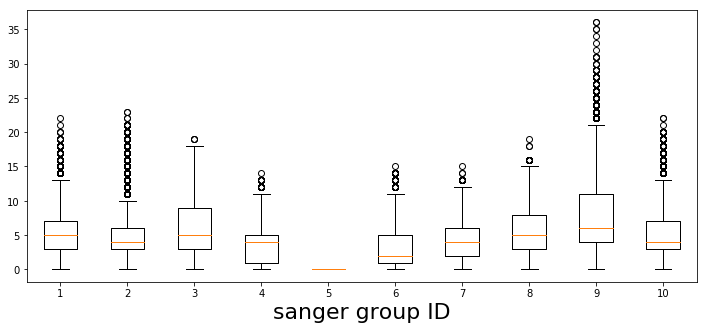

In [799]:
plt.figure(figsize=(12,5))
bp = plt.boxplot(dist_vec_dict.values())
plt.xlabel('sanger group ID', fontsize = 22)

It's also interesting to follow-up in more detail on the pairs of genes with largest distances. 

In [312]:
print([len(dist_vec) for dist_vec in dist_vec_dict.values()])
print([np.median(dist_vec) for dist_vec in dist_vec_dict.values()])

[7875, 23871, 703, 3916, 1, 1326, 4851, 1711, 21945, 9591]
[5.0, 4.0, 5.0, 4.0, 0.0, 2.0, 4.0, 5.0, 6.0, 4.0]


What's this group of genes that appears to have shorter pairwise distances? 

In [296]:
df_sanger_I_list[3].sanger.unique()
print('it\'s the I.D.X group --> Amino acid biosynthesis')

it's the I.D.X group --> Amino acid biosynthesis


In [293]:
df_sanger_I_list[5].sanger.unique()
print('it\'s the I.F.X group --> purines, pyrimidines, nucleosides and nucleotides')

it's the I.F.X group --> purines, pyrimidines, nucleosides and nucleotides


In [298]:
df_sanger_I_list[6].sanger.unique()
print('it\'s the I.G.X group --> Biosynthesis of cofactors')

it's the I.G.X group --> Biosynthesis of cofactors


In [810]:
df_sanger_I_list[0].sanger.unique()
#print('it\'s the I.D.X group --> Amino acid biosynthesis')

array(['I.A.3', 'I.A.1', 'I.A.2', 'I.A.4'], dtype=object)

?????
?????
?????
How can you follow-up on this? 
?????
?????
?????


A natural question to ask is: what do the phenotypic profiles of these genes tend to look like? 

_________
_________
Here's an interesting idea: find a set of genes of unknown function that are 
1. "close to *all* I.F.X genes"
2. "far from all other categories of genes"

Give those genes a large probability of belonging to category I.F.X

to do this, for every candidate gene of unknown function, compute: 
1. The distance to every I.F.X gene, and store in an array
2. The distance to every non-I.F.X gene, and store in an array
3. Assign to each gene a score that looks something like 
   * S = $\frac{<D(x,OTHER)>}{<D(x,I.F.X)>}$

_________
_________

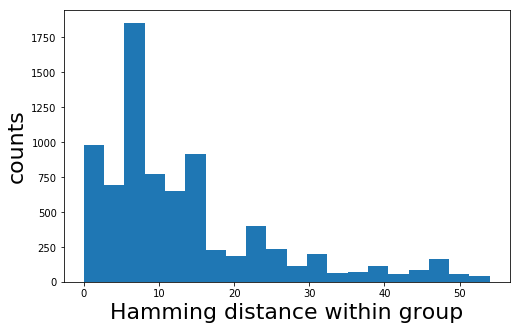

In [266]:
plt.figure(figsize=(8,5))
plt.hist(dist_vec, 20)
plt.xlabel('Hamming distance within group', fontsize = 22)
yl = plt.ylabel('counts', fontsize = 22)

## Compute distances for all genes between groups:

NOTE: I'm concerned that this random sampling is somehow biased - i.e. you're not giving a correct sampling probability that's proportional to the number of genes in each group. 

ALTERNATIVE: You may want to compare against just random pairs of genes. 

In [530]:
# Strategy one: 
dist_vec_diff_dict = {}
for k in range(5):
    print(k)
    dist_vec_diff_groups = []
    num_iter = 4000
    for ii in range(num_iter):

        ind1, ind2 = random.sample(range(len(df_sanger_I_list)), 2)
        # choose randomly chosen gene from randomly chosen group 1: 
        rv_ids_rand_1 = df_sanger_I_list[ind1].Rv_ID.tolist()
        rv_ids_rand_1 = [rv_id for rv_id in rv_ids_rand_1 if not(rv_id in rv_ids_zeros)]
        rv_id_rand_1 = random.sample(rv_ids_rand_1, 1)[0]
        # choose randomly chosen gene from randomly chosen group 2:
        rv_ids_rand_2 = df_sanger_I_list[ind2].Rv_ID.tolist()
        rv_ids_rand_2 = [rv_id for rv_id in rv_ids_rand_2 if not(rv_id in rv_ids_zeros)]
        rv_id_rand_2 = random.sample(rv_ids_rand_2, 1)[0]

        pheno_vec_1 = get_pheno_vec(rv_id_rand_1, df_tn_nonzeros)
        pheno_vec_2 = get_pheno_vec(rv_id_rand_2, df_tn_nonzeros)

        dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
        dist_vec_diff_groups.append(dist_temp)
    dist_vec_diff_dict[k] = dist_vec_diff_groups

0
1
2
3
4


Text(0.5, 0, 'random diff group iteration')

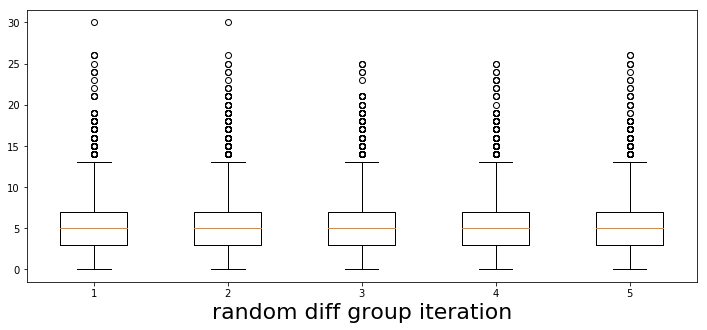

In [314]:
plt.figure(figsize=(12,5))
bp = plt.boxplot(dist_vec_diff_dict.values())
plt.xlabel('random diff group iteration', fontsize = 22)

In [315]:
print([len(dist_vec) for dist_vec in dist_vec_diff_dict.values()])
print([np.median(dist_vec) for dist_vec in dist_vec_diff_dict.values()])

[4000, 4000, 4000, 4000, 4000]
[5.0, 5.0, 5.0, 5.0, 5.0]


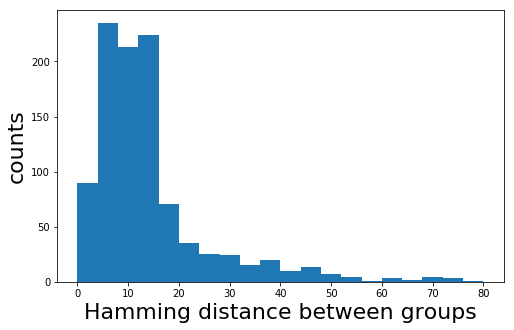

In [269]:
plt.figure(figsize=(8,5))
plt.hist(dist_vec_diff_groups, 20)
plt.xlabel('Hamming distance between groups', fontsize = 22)
yl = plt.ylabel('counts', fontsize = 22)

In [270]:
np.median(dist_vec_diff_groups)

10.0

In [345]:
df_sanger_I_list[9].sanger.unique()

array(['I.J.3', 'I.J.1', 'I.J.2'], dtype=object)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text yticklabel objects>)

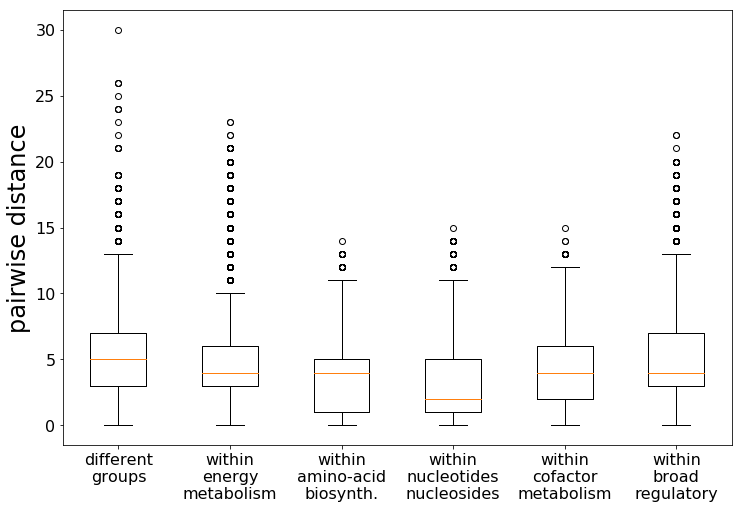

In [346]:
data = [dist_vec_diff_dict[0], dist_vec_dict[1], dist_vec_dict[3], dist_vec_dict[5], dist_vec_dict[6], dist_vec_dict[9]]
plt.figure(figsize=(12,8))
bp = plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6], ['different\ngroups', 'within\nenergy\nmetabolism', 
                                'within\namino-acid\nbiosynth.', 'within\nnucleotides\nnucleosides', 
                                'within\ncofactor\nmetabolism', 'within\nbroad\nregulatory'], fontsize = 16)
plt.xlabel('', fontsize = 22)
plt.ylabel('pairwise distance', fontsize = 24)
plt.yticks(fontsize = 16)

In [359]:
import seaborn as sns

/Users/ajinich/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


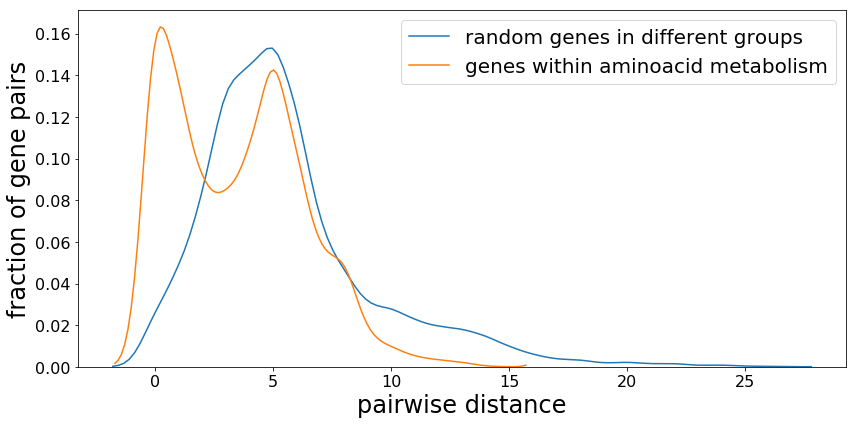

In [800]:
plt.figure(figsize = (12, 6))
dp = sns.distplot(dist_vec_diff_dict[0], hist=False, label='')
dp = sns.distplot(dist_vec_dict[3], hist=False, label='')
#  dp = sns.distplot(dist_vec_dict[5], hist=False, label='')
plt.xlabel('pairwise distance', fontsize = 24)
plt.xticks(fontsize = 16)
plt.ylabel('fraction of gene pairs', fontsize = 24)
plt.yticks(fontsize = 16)
plt.legend(['random genes in different groups', 'genes within aminoacid metabolism'], fontsize = 20)
plt.tight_layout()
plt.savefig('within_aa_metabolism_vs_rand.png', dpi = 200)

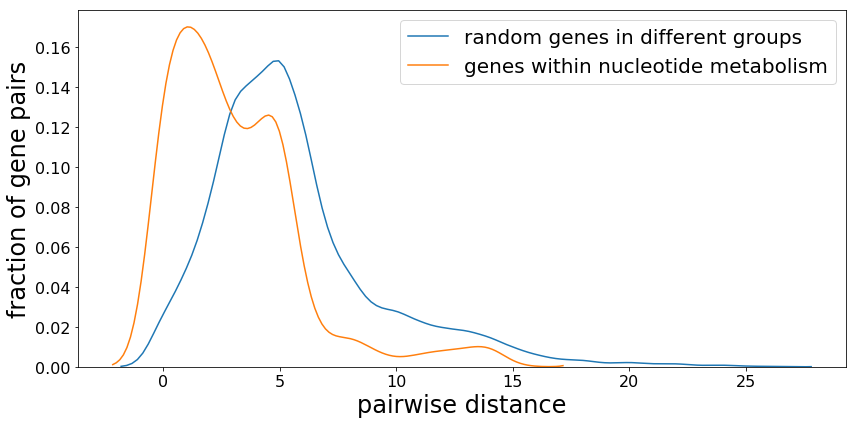

In [801]:
plt.figure(figsize = (12, 6))
dp = sns.distplot(dist_vec_diff_dict[0], hist=False, label='')
dp = sns.distplot(dist_vec_dict[5], hist=False, label='')
plt.xlabel('pairwise distance', fontsize = 24)
plt.xticks(fontsize = 16)
plt.ylabel('fraction of gene pairs', fontsize = 24)
plt.yticks(fontsize = 16)
plt.legend(['random genes in different groups', 'genes within nucleotide metabolism'], fontsize = 20)
plt.tight_layout()
plt.savefig('within_nucleotide_metabolism_vs_rand.png', dpi = 200)

### What do the essentiality profiles of these categories look like? 

In [48]:
def essentiality_calls(df, gene_id):
# Return the columns in which a given gene is called essential:
    
    cols = df.columns[2:]
    col_list = []
    for col in cols:
        if df[df['Rv_ID']==gene_id][col].values[0] == 1:
            col_list.append(col)
            
    return col_list

In [53]:
rv_ids_test = df_sanger_I_list[3].Rv_ID.tolist()
rv_ids_test = [rv_id for rv_id in rv_ids_test if not(rv_id in rv_ids_zeros)]

In [54]:
Tn_profile = [essentiality_calls(df_tn, gene_id) for gene_id in rv_ids_test] 

for i in range(len(rv_ids_test)):
    print(rv_ids_test[i], ': essentiality:\n', Tn_profile[i])

Rv0070c : essentiality:
 ['Rv3005c', 'all_Tn_score']
Rv0189c : essentiality:
 ['2003A_Sassetti', '2012_Zhang', '2013_DeJesus', '2017A_DeJesus']
Rv0337c : essentiality:
 ['2003A_Sassetti', '2012_Zhang', '2013_DeJesus', '2017A_DeJesus', '2018_Carey_1B', '2018_Carey_1C', '2018_Carey_1E', '2018_Carey_1G', '2018_Carey_1H']
Rv0391 : essentiality:
 ['2011_Griffin_2', '2012_Zhang', 'Rv0307c']
Rv0500 : essentiality:
 ['2003A_Sassetti', '2012_Zhang', '2013_DeJesus', '2017A_DeJesus']
Rv0505c : essentiality:
 ['2013_DeJesus', '2013_Zhang_1', '2018_Carey_1A']
Rv0511 : essentiality:
 ['2003A_Sassetti', '2012_Zhang', '2013_DeJesus', '2017A_DeJesus']
Rv0884c : essentiality:
 ['2003A_Sassetti', '2012_Zhang', '2013_DeJesus', '2017A_DeJesus']
Rv1077 : essentiality:
 ['2015_Mendum', 'all_Tn_score']
Rv1079 : essentiality:
 ['2005_Rengarajan', '2012_Zhang', 'Rv0307c']
Rv1093 : essentiality:
 ['2012_Zhang', '2013_DeJesus', '2017A_DeJesus', '2018_Carey_1B', '2018_Carey_1E', '2018_Carey_1F', '2018_Carey_1G', '

# Compute the distance of all genes of unknown function to e.g. all genes in nucleotide metabolism

In [401]:
df_uk = pd.read_csv('unknown_ALL_levels_essential_scores.csv')

In [427]:
rv_id_uk = list(df_uk[df_uk.UK_score_4 == 4].Rv_ID.values)
rv_id_uk_nz = [rv_id for rv_id in rv_id_uk if not(rv_id in rv_ids_zeros)]

rv_id_aas = df_sanger_I_list[3].Rv_ID.tolist()
rv_id_aas_nz = [rv_id for rv_id in rv_id_aas if not(rv_id in rv_ids_zeros)]

rv_id_nucleotides = df_sanger_I_list[5].Rv_ID.tolist()
rv_id_nucleotides_nz = [rv_id for rv_id in rv_id_nucleotides if not(rv_id in rv_ids_zeros)]


In [428]:
print(len(rv_id_uk_nz), len(rv_id_nucleotides_nz), len(rv_id_aas_nz))

557 51 88


In [429]:
counter = 0
dist_vec_UK_to_nucleotides = []
for rv_id in rv_id_uk_nz: # for each non-zero gene of unknown function: 
    if counter%50==0:
        print(counter, 'out of', len(rv_id_uk_nz))
    pheno_vec_1 = get_pheno_vec(rv_id, df_tn_nonzeros)
    dist_list = []
    for rv_id_2 in rv_id_nucleotides_nz: # for each gene in the sanger nucleotide category
        pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)
        dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
        dist_list.append(dist_temp)
    dist_vec_UK_to_nucleotides.append(dist_list)
    counter += 1

0 out of 557
50 out of 557
100 out of 557
150 out of 557
200 out of 557
250 out of 557
300 out of 557
350 out of 557
400 out of 557
450 out of 557
500 out of 557
550 out of 557


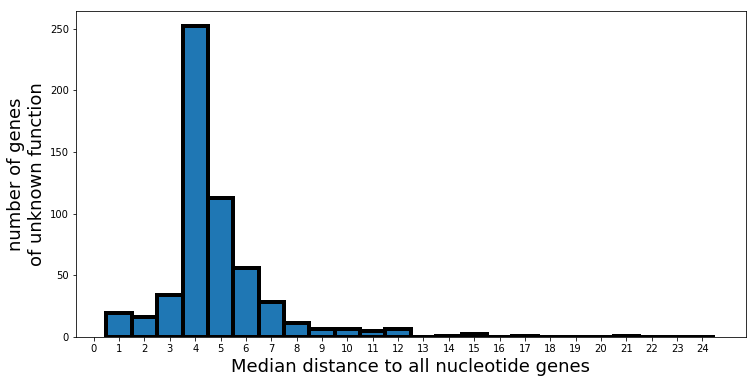

In [619]:
dist_medians_UK = [np.median(dist_list) for dist_list in dist_vec_UK_to_nucleotides]
plt.figure(figsize = (12, 6))
hst = plt.hist(dist_medians_UK, bins = np.arange(0.5, 25, 1), edgecolor='black', linewidth=4)
plt.xlabel('Median distance to all nucleotide genes', fontsize = 18)
plt.ylabel('number of genes\nof unknown function', fontsize = 18)
xt = plt.xticks(np.arange(0, 25, 1))

In [620]:
d = 1
prob_dist_cum(dist_medians_UK, d)

0.03411131059245961

How do I find the name of those few genes of unknown function that are closest to all the nucleotide genes?

In [464]:
# indices of genes with median distance of 1:
ind_dist_1 = [i for i in range(len(dist_medians)) if dist_medians[i] == 1]
# indices of genes with median distance of 2:
ind_dist_2 = [i for i in range(len(dist_medians)) if dist_medians[i] == 2]
# indices of genes with median distance of 12:
ind_dist_12 = [i for i in range(len(dist_medians)) if dist_medians[i] == 12]

# gene lists at those distances: 
rv_id_dist_1 = list(np.array(rv_id_uk_nz)[ind_dist_1])
rv_id_dist_2 = list(np.array(rv_id_uk_nz)[ind_dist_2])
rv_id_dist_12 = list(np.array(rv_id_uk_nz)[ind_dist_12])

In [472]:
# verifying a couple of cases: 
rv_id = rv_id_dist_1[-1]
pheno_vec_1 = get_pheno_vec(rv_id, df_tn_nonzeros)
dist_list = []
for rv_id_2 in rv_id_nucleotides_nz: # for each gene in the sanger nucleotide category
    pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)
    dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
    dist_list.append(dist_temp)

In [621]:
len(rv_id_dist_1)

19

Digging deeper into a few of these: 

Those that are consistent with the hypothesis: 
* Rv1697 has a Pfam domain "thiamin pyrophosphokinase"
* Rv2698: according to STRING-DB, by "neighborhood homology", it's close to 'dut', Deoxyuridine 5’-triphosphate nucleotidohydrolase
* Rv0060, according to STRING-DB, close to a putative ribonuclease.
* [OTHERS?]

Those that are weird: 
* Rv3030, Probable S-adenosylmethionine-dependent methyltransferase required for the 6-O-methylation of the polysaccharide backbone of 6-O-methylglucosyl lipopolysaccharides (MGLP)
* Rv3031, 4-alpha-glucan branching enzyme 


You also need to know the genes within the "rv_id_nucleotides_nz" Sanger group:
* Rv0321: deoxycytidine triphosphate deaminase -- Pyrimidine metabolism
* Rv0357c: Adenylosuccinate synthetase; Plays an important role in the de novo pathway of purine nucleotide biosynthesis.
* [OTHERS?]


### Now compare to the distribution of random genes to all nucleotide genes. 

How do I build a list of ~500 genes that are *not* sanger nucleotide genes (with non-zero phenotypic profiles)
* you could randomly sample genes from other sub-groups in the I group: (all except element 5 in df_sanger_I_list)

In [524]:
df_non_nucleotides = df_sanger_I[~df_sanger_I.sanger.str.contains('^I.F')]
rand_non_nuc = list(df_non_nucleotides.sample(700).Rv_ID.values)
rand_non_nuc_nz = [rv_id for rv_id in rand_non_nuc if not(rv_id in rv_ids_zeros)]
len(rand_non_nuc_nz)

547

In [ ]:
counter = 0
dist_vec_nonnuc_to_nuc = []
for rv_id in rand_non_nuc_nz: # for each non-zero gene of unknown function: 
    if counter%50==0:
        print(counter, 'out of', len(rand_non_nuc_nz))
    pheno_vec_1 = get_pheno_vec(rv_id, df_tn_nonzeros)
    dist_list = []
    for rv_id_2 in rv_id_nucleotides_nz: # for each gene in the sanger nucleotide category
        pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)
        dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
        dist_list.append(dist_temp)
    dist_vec_nonnuc_to_nuc.append(dist_list)
    counter += 1

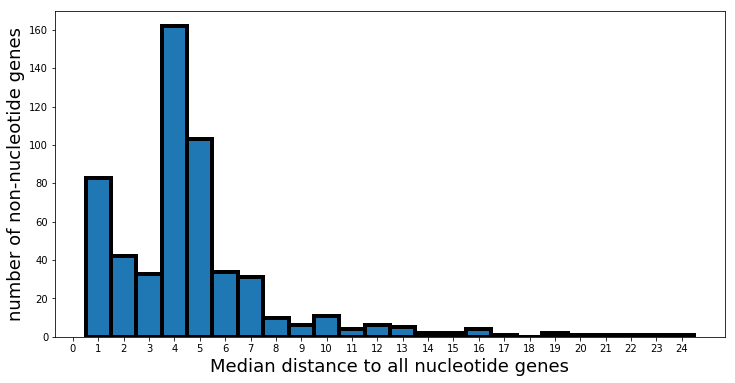

In [526]:
dist_medians_nonnuc = [np.median(dist_list) for dist_list in dist_vec_nonnuc_to_nuc]
plt.figure(figsize = (12, 6))
hst = plt.hist(dist_medians_nonnuc, bins = np.arange(0.5, 25, 1), edgecolor='black', linewidth=4)
plt.xlabel('Median distance to all nucleotide genes', fontsize = 18)
plt.ylabel('number of non-nucleotide genes', fontsize = 18)
xt = plt.xticks(np.arange(0, 25, 1))

This says that if you randomly pick a non-nucleotide metabolism gene:
* there's a 15% chance that its median distance to all nucleotide genes is 1
* there's a 23% chance that its median distance to all nucleotide genes is 2 or less

In [604]:
d = 1
prob_dist_cum(dist_medians_nonnuc, d)

0.15173674588665448

Here's a different way to do it:

In [605]:
rv_ids_nz = [rv_id for rv_id in df_tn.Rv_ID.values if not(rv_id in rv_ids_zeros)]

In [613]:
rv_ids_nz_rand = random.sample(rv_ids_nz, 500)

In [ ]:
counter = 0
dist_vec_rand_to_nuc = []
for rv_id in rv_ids_nz_rand: # for each non-zero gene of unknown function: 
    if counter%50==0:
        print(counter, 'out of', len(rv_ids_nz_rand))
    pheno_vec_1 = get_pheno_vec(rv_id, df_tn_nonzeros)
    dist_list = []
    for rv_id_2 in rv_id_nucleotides_nz: # for each gene in the sanger nucleotide category
        pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)
        dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
        dist_list.append(dist_temp)
    dist_vec_rand_to_nuc.append(dist_list)
    counter += 1

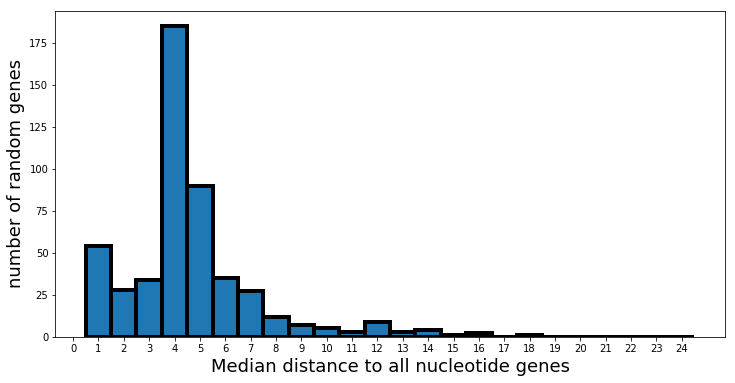

In [615]:
dist_medians_rand = [np.median(dist_list) for dist_list in dist_vec_rand_to_nuc]
plt.figure(figsize = (12, 6))
hst = plt.hist(dist_medians_rand, bins = np.arange(0.5, 25, 1), edgecolor='black', linewidth=4)
plt.xlabel('Median distance to all nucleotide genes', fontsize = 18)
plt.ylabel('number of random genes', fontsize = 18)
xt = plt.xticks(np.arange(0, 25, 1))

This says that if you randomly pick a gene:
* there's a 10% chance that its median distance to all nucleotide genes is 1
* there's a 16% chance that its median distance to all nucleotide genes is 2 or less

In [618]:
d = 1
prob_dist_cum(dist_medians_rand, d)

0.108

What does the histogram for genes *within* nucleotide metabolism look like again? 

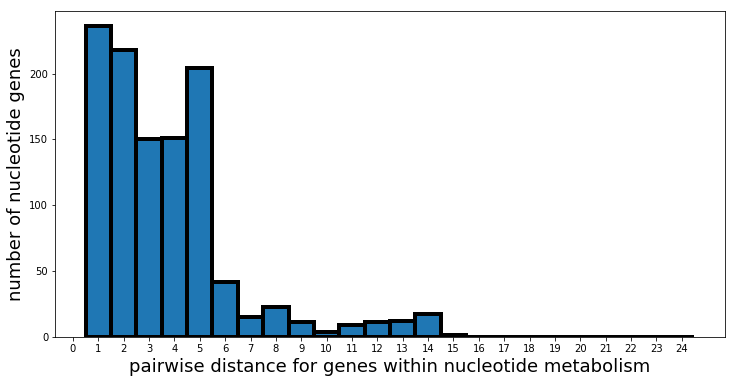

In [597]:
plt.figure(figsize = (12, 6))
hst = plt.hist(dist_vec_dict[5], bins = np.arange(0.5, 25, 1), edgecolor='black', linewidth=4)
plt.xlabel('pairwise distance for genes within nucleotide metabolism', fontsize = 18)
plt.ylabel('number of nucleotide genes', fontsize = 18)
xt = plt.xticks(np.arange(0, 25, 1))

## You should get to know some other "background" pairwise distance distributions: 

Random pairs of genes (non-zero Tn-Mat profiles) selected from the entire genome: 

In [533]:
rv_ids_nz = [rv_id for rv_id in df_tn.Rv_ID.values if not(rv_id in rv_ids_zeros)]

In [548]:
num_iter = 10000
dist_list = []
for n in range(num_iter):
    rv_id_1, rv_id_2 = random.sample(rv_ids_nz, 2)
    pheno_vec_1 = get_pheno_vec(rv_id_1, df_tn_nonzeros)
    pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)
    dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
    dist_list.append(dist_temp)

In [550]:
rand_gene_pairs_dist = dist_list.copy()

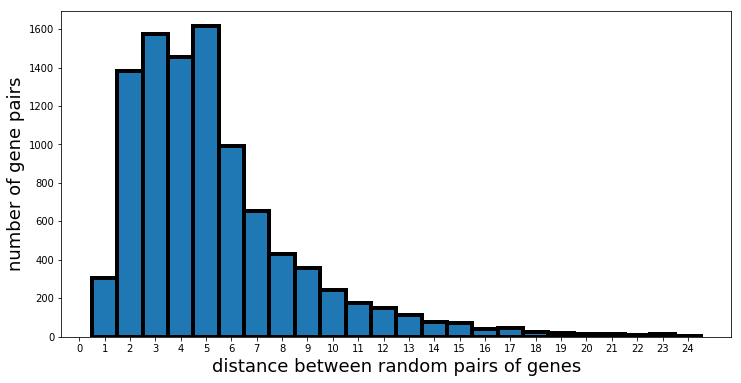

In [549]:
plt.figure(figsize = (12, 6))
hst = plt.hist(dist_list, bins = np.arange(0.5, 25, 1), edgecolor='black', linewidth=4)
plt.xlabel('distance between random pairs of genes', fontsize = 18)
plt.ylabel('number of gene pairs', fontsize = 18)
xt = plt.xticks(np.arange(0, 25, 1))

Probability that a random pair of genes has a distance <= d?

In [568]:
d = 2
prob_dist_cum(rand_gene_pairs_dist, d)

0.1911

How does this compare to distance distributions within groups? 

In [574]:
# amino acid biosynthesis
d = 1
prob_dist_cum(dist_vec_dict[3], d)

0.329417773237998

In [575]:
# nucleotide metabolism
d = 1
prob_dist_cum(dist_vec_dict[5], d)

0.3453996983408748

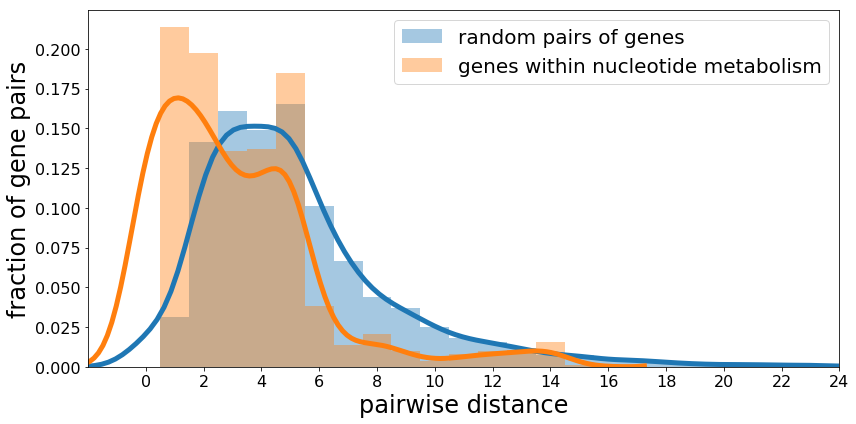

In [813]:
plt.figure(figsize = (12, 6))
dp = sns.distplot(rand_gene_pairs_dist, bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
dp = sns.distplot(dist_vec_dict[5], bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
plt.xlabel('pairwise distance', fontsize = 24)
plt.xticks(fontsize = 16)
plt.ylabel('fraction of gene pairs', fontsize = 24)
plt.yticks(fontsize = 16)

xt = plt.xticks(np.arange(0, 25, 2))
plt.xlim(-2,24)
plt.legend(['random pairs of genes', 'genes within nucleotide metabolism'], fontsize = 20)
plt.tight_layout()
plt.savefig('within_nucleotide_metabolism_vs_rand.png', dpi = 200)

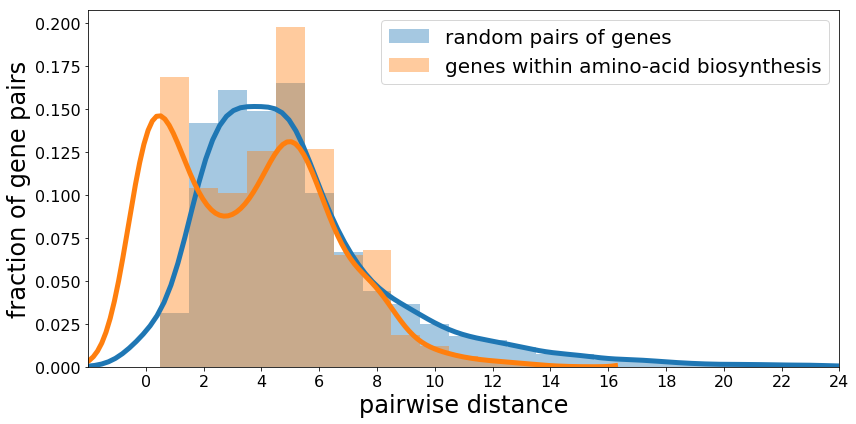

In [820]:
plt.figure(figsize = (12, 6))
dp = sns.distplot(rand_gene_pairs_dist, bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
dp = sns.distplot(dist_vec_dict[3], bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
plt.xlabel('pairwise distance', fontsize = 24)
plt.xticks(fontsize = 16)
plt.ylabel('fraction of gene pairs', fontsize = 24)
plt.yticks(fontsize = 16)

xt = plt.xticks(np.arange(0, 25, 2))
plt.xlim(-2,24)
plt.legend(['random pairs of genes', 'genes within amino-acid biosynthesis'], fontsize = 20)
plt.tight_layout()
plt.savefig('within_aminoacid_metabolism_vs_rand.png', dpi = 200)

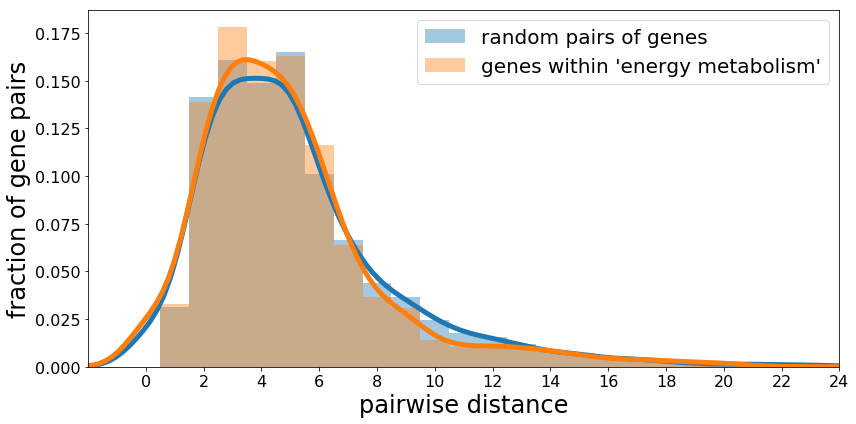

In [819]:
plt.figure(figsize = (12, 6))
dp = sns.distplot(rand_gene_pairs_dist, bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
dp = sns.distplot(dist_vec_dict[1], bins = np.arange(0.5, 25, 1), norm_hist=True, kde = True, label='', kde_kws={'bw': .75, 'lw':5})
plt.xlabel('pairwise distance', fontsize = 24)
plt.xticks(fontsize = 16)
plt.ylabel('fraction of gene pairs', fontsize = 24)
plt.yticks(fontsize = 16)

xt = plt.xticks(np.arange(0, 25, 2))
plt.xlim(-2,24)
plt.legend(['random pairs of genes', 'genes within \'energy metabolism\''], fontsize = 20)
plt.tight_layout()
plt.savefig('within_energy_metabolism_vs_rand.png', dpi = 200)

This is pretty promising. 

Does the pairwise distance distribution tell you something about the structure? is there some sort of core cluster? 

Lo que falta es caracterizar el "phenotypic profile" de los genes que pertenecen a estos grupos

# Below are some sketches for the BRB-11 lab floor meeting:

In [684]:
def rand_in_circle(x_center, y_center, rad):
    rand_ang = 2*np.pi*random.random()
    rand_rad = rad*random.random()
    #convert to cartesian, accounting for circle's radius:
    x = rand_rad*np.cos(rand_ang) + x_center
    y = rand_rad*np.sin(rand_ang) + y_center
    return x, y

In [765]:
def draw_rand_in_circle(x_center, y_center, rad, num_points):
    xy_list = []
    for k in range(num_points):
        x,y = rand_in_circle(x_center, y_center, rad)
        plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
        xy_list.append([x,y])
    return xy_list

def sample_rand_in_circle(x_center, y_center, rad, num_points):
    xy_list = []
    for k in range(num_points):
        x,y = rand_in_circle(x_center, y_center, rad)
        xy_list.append([x,y])
    return xy_list

In [723]:
def lines_between_all_pts(xy_list, col_line):
    for i in range(len(xy_list)):
        for j in range(i,len(xy_list)):
            xs = xy_list[i][0], xy_list[j][0]
            ys = xy_list[i][1], xy_list[j][1]
            plt.plot(xs, ys, '--', color = col_line, alpha = 0.25)

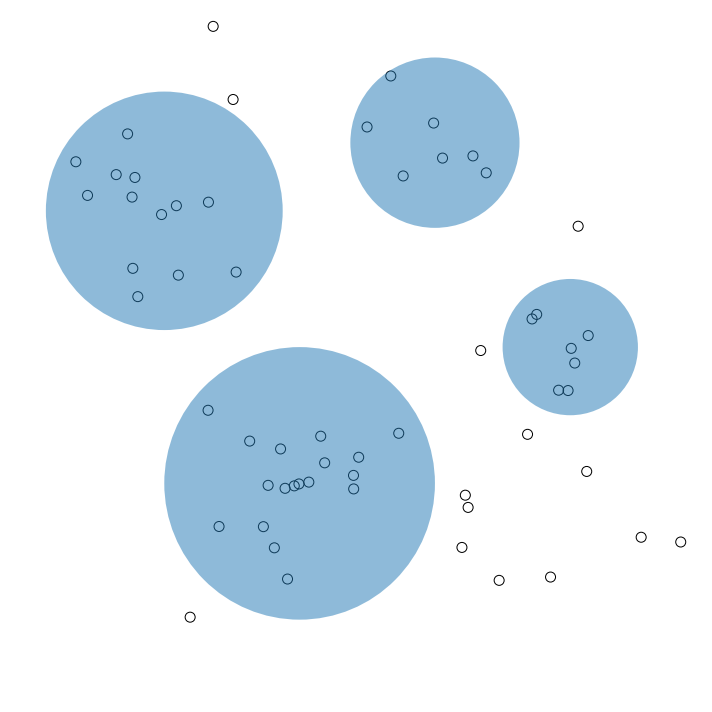

In [806]:
plt.figure(figsize = (10,10))
circle1 = plt.Circle((-3, 2), radius=1.75, alpha = 0.5)
circle2 = plt.Circle((1, 3), radius=1.25, alpha = 0.5)
circle3 = plt.Circle((3, 0), radius=1, alpha = 0.5)
circle4 = plt.Circle((-1, -2), radius=2, alpha = 0.5)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)

# plt.axis('scaled')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.axis('off')

xy_list1 = draw_rand_in_circle(-3, 2, 1.7, 12)
xy_list2 = draw_rand_in_circle(1, 3, 1.2, 6)
xy_list3 = draw_rand_in_circle(3, 0, 0.9, 6)
xy_list4 = draw_rand_in_circle(-1, -2, 1.9, 15)

num_points = 20
xy_list = [(10*random.random()-5, 10*random.random()-5) for i in range(num_points)]
xs = [xy[0] for xy in xy_list]
ys = [xy[1] for xy in xy_list]
plt.scatter(xs, ys, s=100, facecolors='none', edgecolors='k')

plt.tight_layout()
plt.savefig('functional_categories.png', dpi = 200)

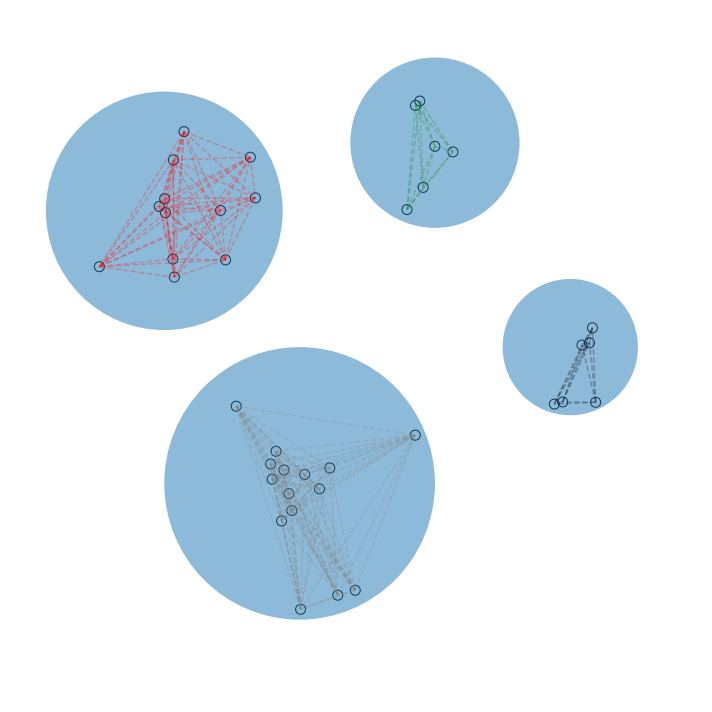

In [789]:
plt.figure(figsize = (10,10))
circle1 = plt.Circle((-3, 2), radius=1.75, alpha = 0.5)
circle2 = plt.Circle((1, 3), radius=1.25, alpha = 0.5)
circle3 = plt.Circle((3, 0), radius=1, alpha = 0.5)
circle4 = plt.Circle((-1, -2), radius=2, alpha = 0.5)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)

# plt.axis('scaled')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.axis('off')

xy_list1 = draw_rand_in_circle(-3, 2, 1.7, 12)
xy_list2 = draw_rand_in_circle(1, 3, 1.2, 6)
xy_list3 = draw_rand_in_circle(3, 0, 0.9, 6)
xy_list4 = draw_rand_in_circle(-1, -2, 1.9, 15)

lines_between_all_pts(xy_list1, 'red')
lines_between_all_pts(xy_list2, 'green')
lines_between_all_pts(xy_list3, 'black')
lines_between_all_pts(xy_list4, 'grey')

plt.tight_layout()
plt.savefig('distance_within_group_schemat.png', dpi = 200)

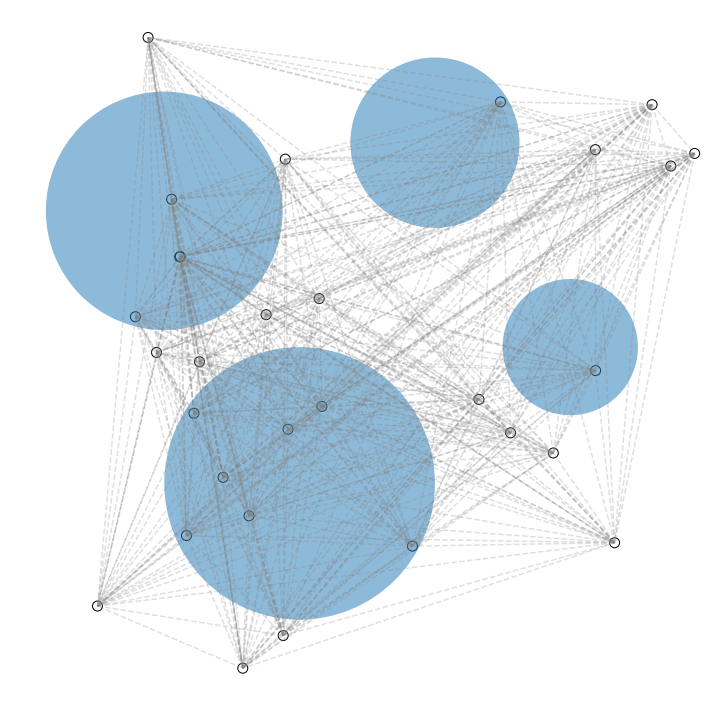

In [790]:
plt.figure(figsize = (10,10))
circle1 = plt.Circle((-3, 2), radius=1.75, alpha = 0.5)
circle2 = plt.Circle((1, 3), radius=1.25, alpha = 0.5)
circle3 = plt.Circle((3, 0), radius=1, alpha = 0.5)
circle4 = plt.Circle((-1, -2), radius=2, alpha = 0.5)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)

# plt.axis('scaled')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.axis('off')

num_points = 30
xy_list = [(10*random.random()-5, 10*random.random()-5) for i in range(num_points)]
xs = [xy[0] for xy in xy_list]
ys = [xy[1] for xy in xy_list]
plt.scatter(xs, ys, s=100, facecolors='none', edgecolors='k')

lines_between_all_pts(xy_list, 'grey')
plt.tight_layout()
plt.savefig('distance_random_genes_schemat.png', dpi = 200)

In [774]:
xy_list_c = sample_rand_in_circle(-3, 2, 1.7, 12)

In [791]:
counter = 0

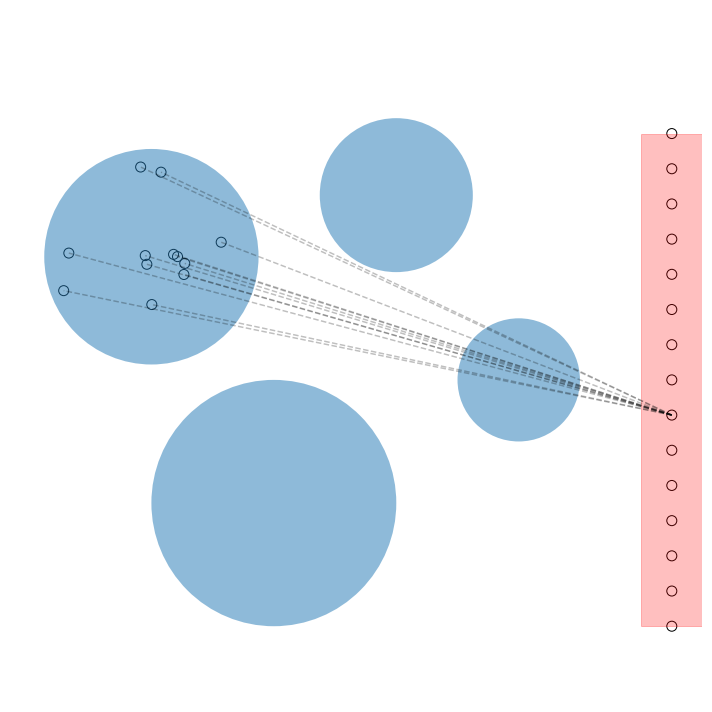

In [798]:
plt.figure(figsize = (10,10))
circle1 = plt.Circle((-3, 2), radius=1.75, alpha = 0.5)
circle2 = plt.Circle((1, 3), radius=1.25, alpha = 0.5)
circle3 = plt.Circle((3, 0), radius=1, alpha = 0.5)
circle4 = plt.Circle((-1, -2), radius=2, alpha = 0.5)

rectangle = plt.Rectangle((5, -4), 1, 8, alpha = 0.25, color = 'red')

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)
plt.gca().add_patch(rectangle)


# plt.axis('scaled')
plt.xlim(-5,6)
plt.ylim(-5,6)
plt.axis('off')

plt.scatter([xy[0] for xy in xy_list_c], [xy[1] for xy in xy_list_c], s=100, facecolors='none', edgecolors='k')

num_rec = 15
x_rec = num_rec*[5.5]
y_rec = np.linspace(-4, 4, num_rec)
xy_rec = list(zip(x_rec, y_rec))
plt.scatter(x_rec, y_rec, s=100, facecolors='none', edgecolors='k')

for xy in random.sample(xy_rec, 1):
    for xy2 in xy_list_c:
        xs = xy[0], xy2[0]
        ys = xy[1], xy2[1]
        plt.plot(xs, ys, '--', color = 'k', alpha = 0.25)
        
counter += 1
plt.tight_layout()
        
plt.savefig('distance_UK_to_group'+str(counter)+'.png', dpi = 200)

# visualizing network:

Import library:

In [22]:
import networkx as nx

Initialize graph:

In [70]:
G = nx.Graph()

Add nodes: 

In [71]:
sanger_ind = 3
rv_ids_test = df_sanger_I_list[sanger_ind].Rv_ID.tolist()
rv_ids_test = [rv_id for rv_id in rv_ids_test if not(rv_id in rv_ids_zeros)]
G.add_nodes_from(rv_ids_test)

In [72]:
len(rv_ids_test)

88

Add weighted edges: 

In [73]:
weight_edges = []
for i in np.arange(len(rv_ids_test)):
    for j in np.arange(i+1, len(rv_ids_test)):
        rv_id_1 = rv_ids_test[i]
        rv_id_2 = rv_ids_test[j]

        pheno_vec_1 = get_pheno_vec(rv_id_1, df_tn_nonzeros)
        pheno_vec_2 = get_pheno_vec(rv_id_2, df_tn_nonzeros)

        dist_temp = dist_hamming(pheno_vec_1, pheno_vec_2)
        weight_edges.append((rv_id_1, rv_id_2, dist_temp))

In [74]:
np.median([w[-1] for w in weight_edges])

4.0

In [75]:
G.add_weighted_edges_from(weight_edges)

Write graph: 

In [76]:
path_temp = 'graph_aminoacids.gml'
nx.write_graphml(G, path_temp)

Trying to visualize graph in NetworkX:

In [69]:
n1 = 'Rv2364c'
n2 = 'Rv0777'
[w for w in weight_edges if n1 in w and n2 in w]

[('Rv0777', 'Rv2364c', 1)]

An alternative might be to do something like a tSNE?

/Users/ajinich/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


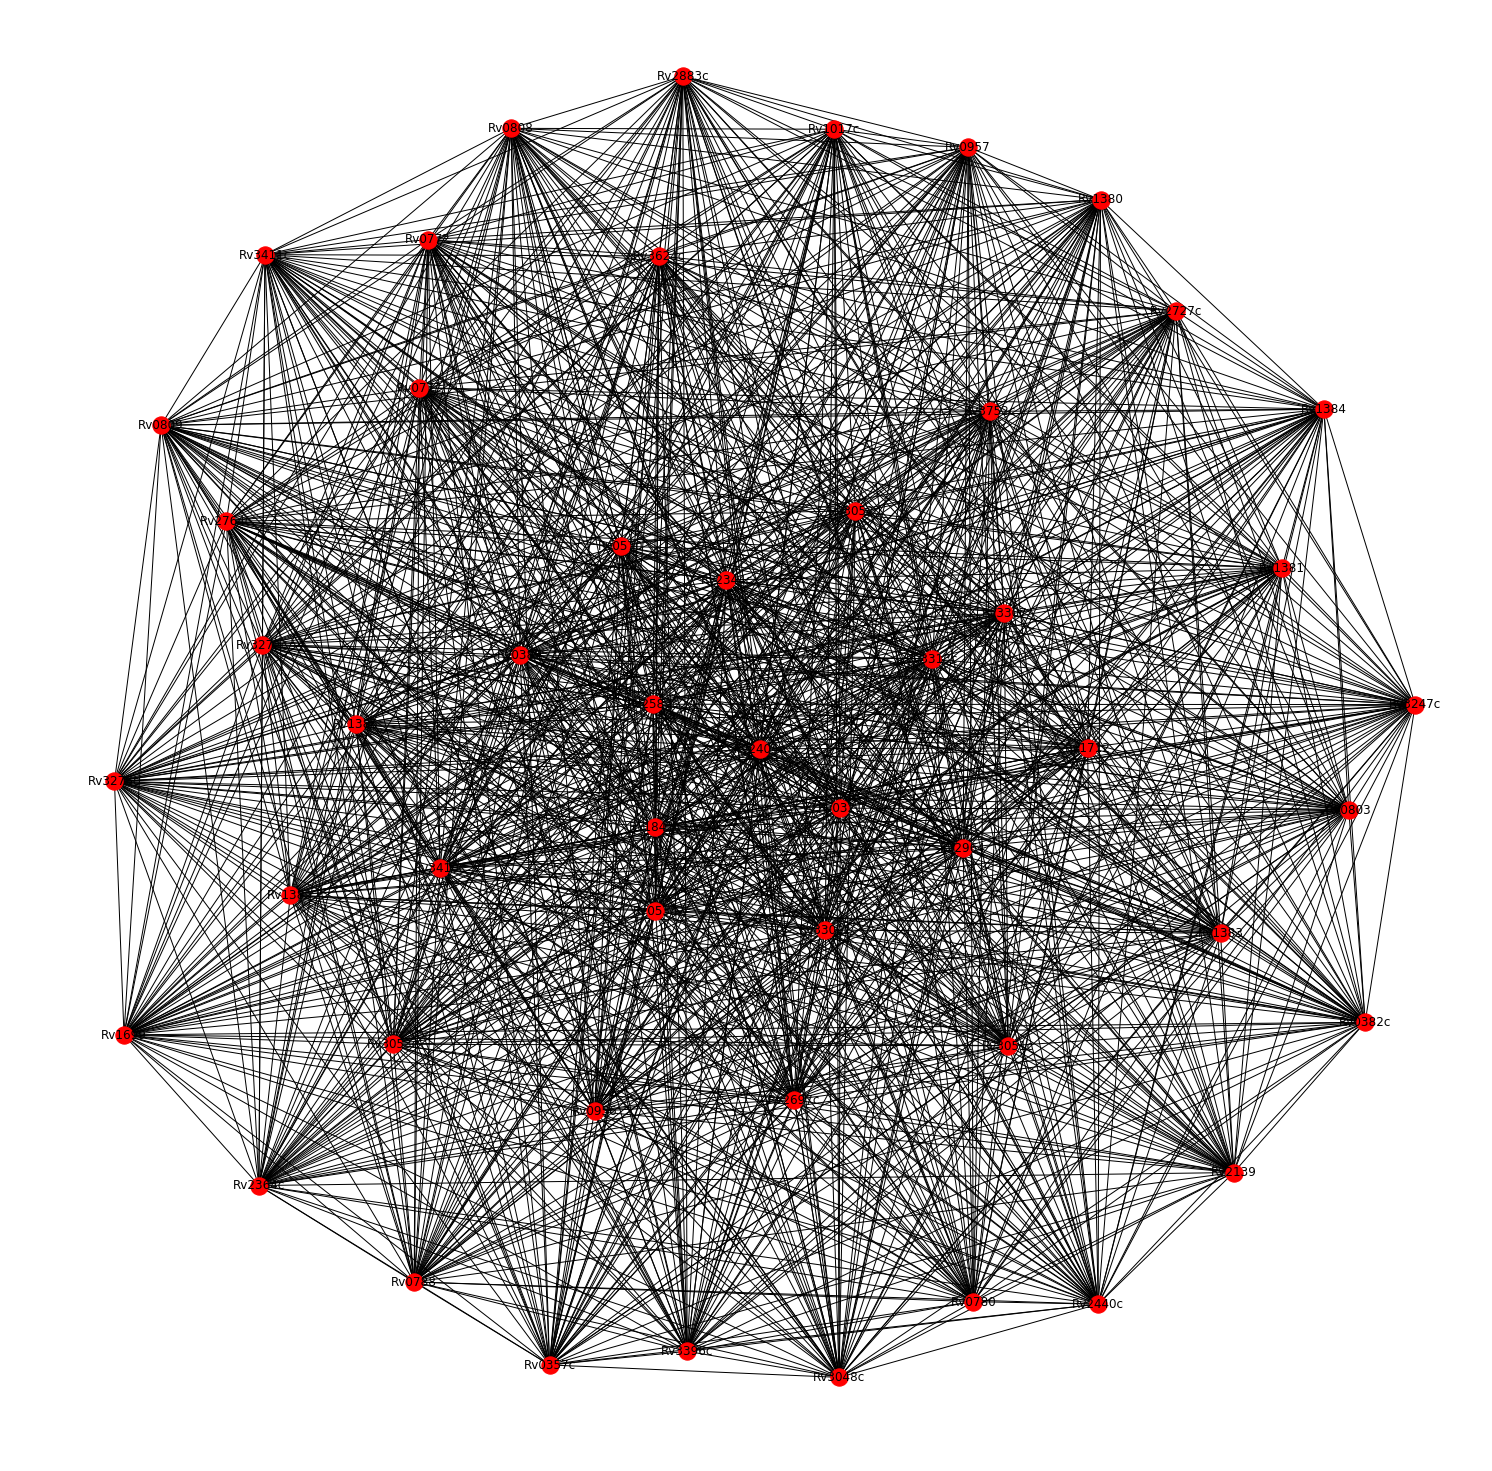

In [848]:
Gtest = nx.petersen_graph()
plt.figure(figsize = (20,20))
nx.draw_spring(G, with_labels=True)